In [1]:
import plotly.graph_objs as go
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['lines.linewidth'] = 0.6

## Хеджирование Uniswap V3 позиций с помощью опционов

В этой статье мы рассмотрим, как с помощью опционов можно хеджировать юнисвоповские позиции 

#### Содержание статьи
- Небольшой remainder:
    - Uniswap V3 позиция
    - Риск-профиль провайдера ликвидности
- Что такое опцион
- Профиль Put опциона
- Совмещаем Uniswap V3 позицию и купленный Put опцион
- Итоги

#### Вводные термины:
- **Базовый актив** - это рассматриваемый актив, в нашем случае токен
- **Хеджировать** - значит защититься от риска. Когда юзер держит рисковый актив (например, эфир, открытая позиция на юнисвопе и т.п.), его стоимость портфеля зависит от цены актива. Захеджировать позицию - значит сделать так, чтобы позиция стала менее зависимой от рискового фактора (в данном случае цены актива)

### Uniswap V3 позиция

Давайте вспомним, как работает Uniswap V3. Провайдеры ликвидности выставляют желаемый price range, в котором будут использоваться их предоставляемые токены, получая комиссии за своп. Чем уже диапазон, тем больше комиссий она будет зарабатывать при каждом свопе. Одна при узком диапазоне цена быстрее выйдет из него, и позиция уже не будет зарабатывать ничего.

Когда кто-то обменивает одни токены на другие, например, USDC на WETH, в пуле становится больше долларов и меньше эфиров. То есть кол-во подорожавшего актива стало меньше, но цена стала чуть больше, и так в каждой Uniswap V3 позиции, которая была активной на момент свопа. Соответственно суммарная стоимость портфеля у провайдера ликвидности поменялась.


### Риск-профиль провайдера ликвидности

Рассмотрим как зависит стоимость позиции провайдера ликвидности в зависимости от цены эфира:

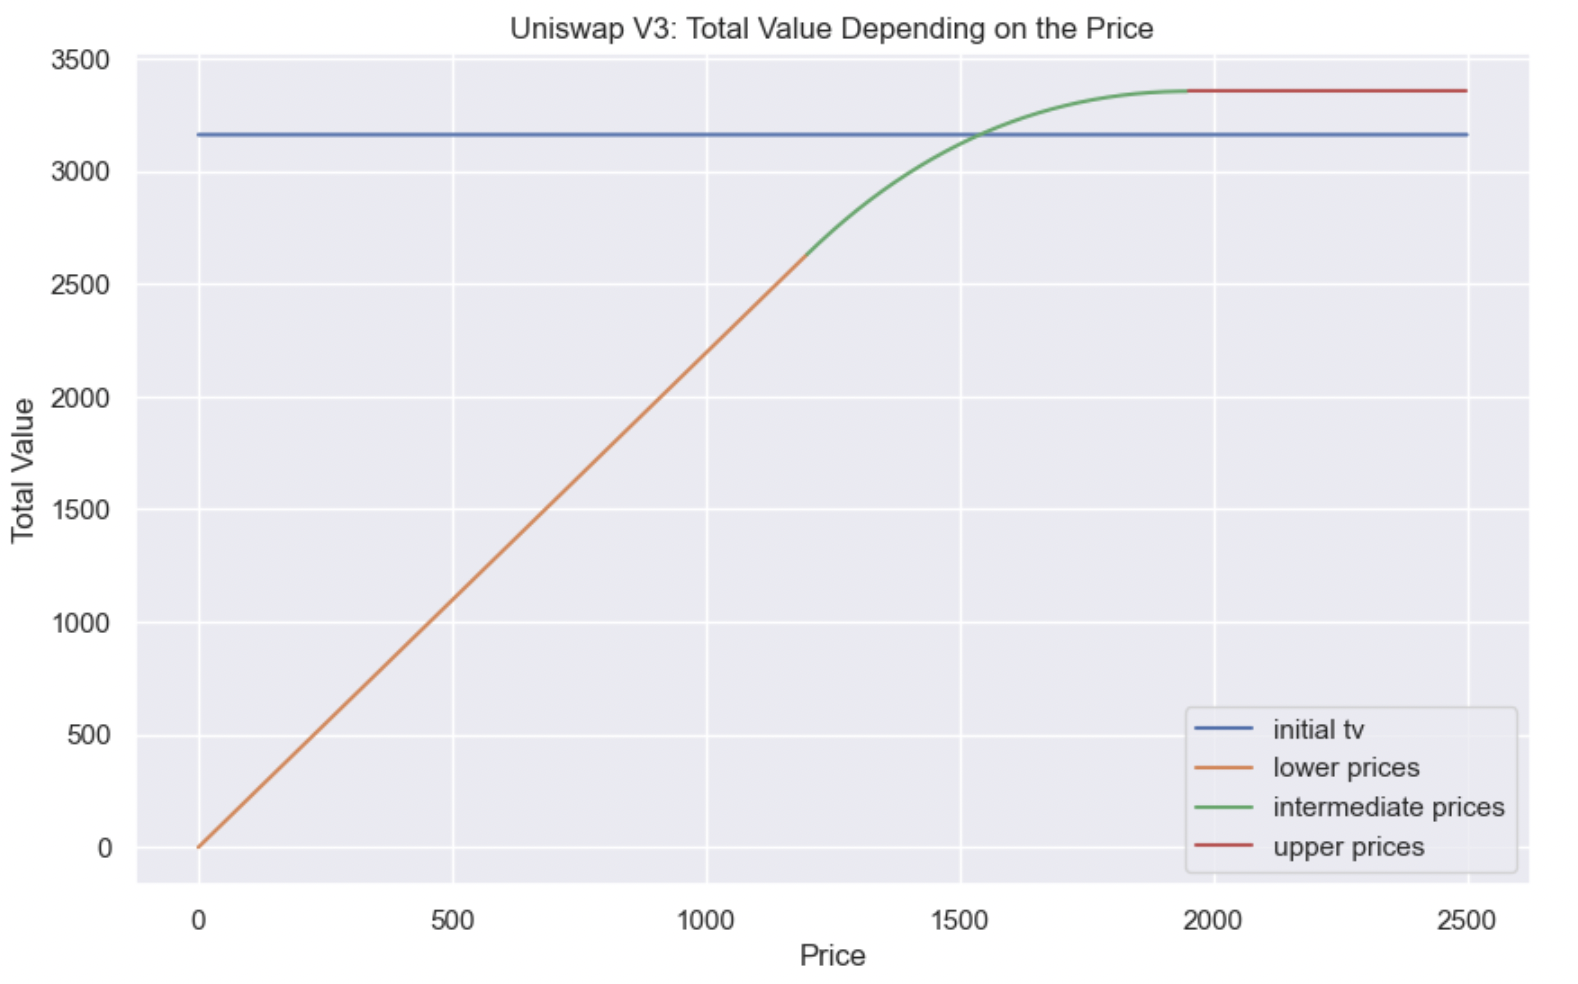

#### В чем проблема такой позиции?

Проблема в том, что если цена пойдёт вниз, то провайдер ликвидности будет фиксировать всё больше и больше убытка. Сначала, из-за кривизны Uniswap V3 позиции (пока цена находится в диапазоне), лосс будет не такой сильный, но по мере движения цены вниз убыток будет всё сильнее возрастать.

Это значит, что **у провайдера ликвидности открытый риск по цене базового актива**. 


#### Что можно сделать?

Можно купить опцион, и благодаря нему провайдер ликвидности не будет так сильно зависим от цены базового актива.

#### Что такое опцион?

**Опцион** - это контракт, который дает право (но не обязательство) купить/продать базовый актив в заранее оговоренный момент времени по заранее оговорённой цене.



Здесь важно, что у покупателя есть право, но не обязательство. То есть он в момент экспирации (истечения) опциона может и не исполнять этот опцион. Например, если этот опцион будет для него невыгоден.

В данной статьей будем рассматривать только европейские опционы, то есть те, которые можно исполнить только в момент истечения самого опциона.

Опционы бывают двух типов: первый тип дает право на покупку, второй тип - право на продажу (в фиксированный момент времени по фиксированной цене).

В нашем случае, чтобы захеджировать провайдера ликвидности, нам нужен опцион, который дает право на продажу.

Опцион, который дает право на продажу (такой опцион называется **Put option**):

### Как посчитать выплату по опциону

Выплата - то есть сколько мы заработаем/потеряем, если купим данный опцион.


Выплата по европейскому **put**-опциону на экспирации определяется формулой:

$$Payoff = max(0, K - S_T) - P_0$$

$S_T$ - цена базового актива на момент экспирации опциона <br/>
$K$ - страйк опциона <br/>
$P_0$ - цена put-опциона на момент покупки ($t=0$)

#### Выплата в зависимости от цены на момент исполнения опциона будет выглядеть так:


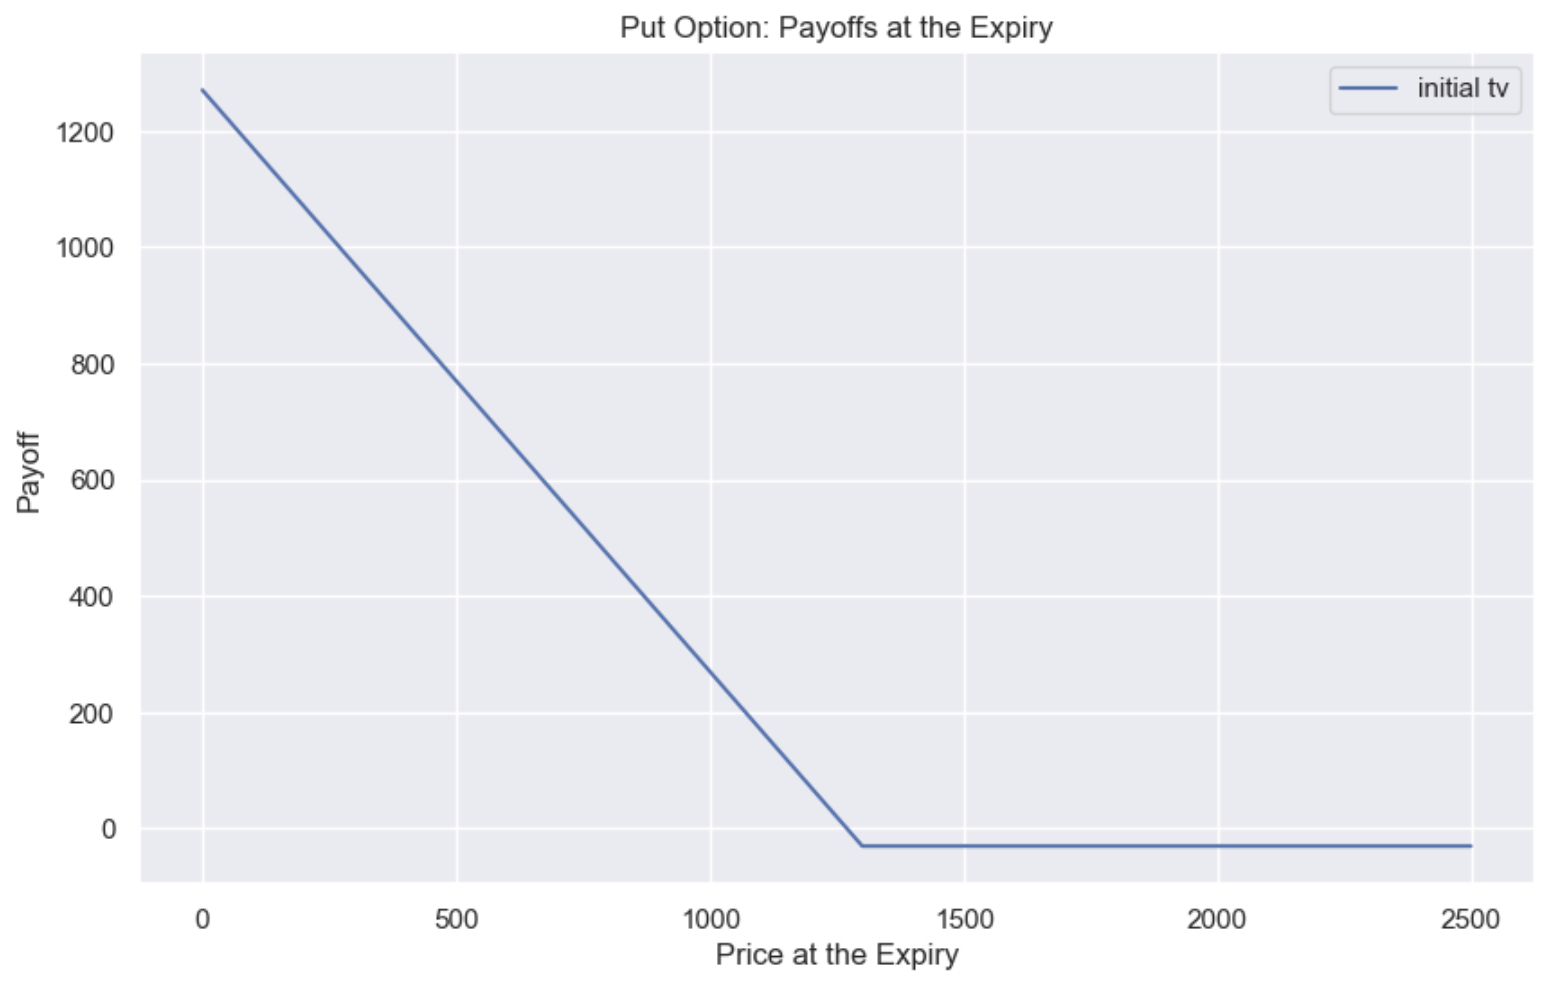

### Что здесь примечательного? 

Такой опцион дает положительную выплату при падении цены базового актива, а в рассматриваемой нами Uniswap V3 позиции мы теряем деньги при движении цены вниз.

#### Поэтому давайте "купим" такой опцион, то есть сложим два графика и посмотрим что будет:

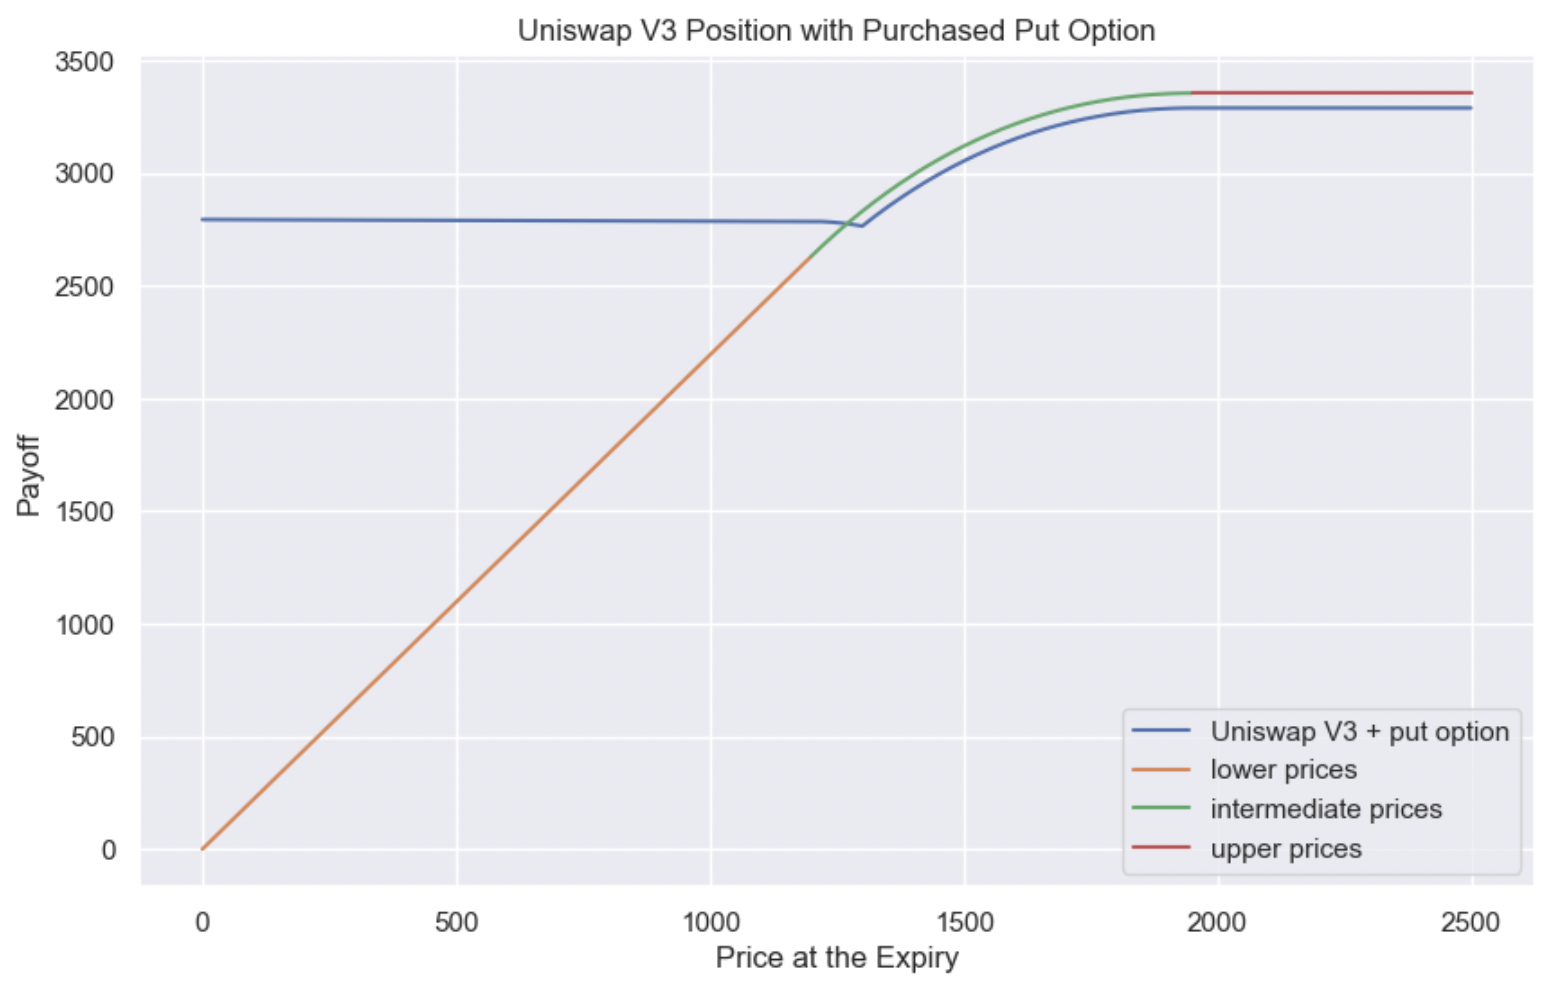

В примере выше мы купили не один опцион, а 1.8 чтобы в сумме Uniswap V3 позиция и опцион давали около-горизонтальный график.

### Важно:
- В данном примере  стоимость опциона была взята "наобум", чисто чтобы показать как работает хеджирование с помощью опциона.
- Чем сильнее покупаемый опцион "в деньгах", тем больше будет его стоимость покупки (логично, ведь если при цене эфира 1500 опцион дает право на покупку по 1200, то и стоить он должен недешево)

### Можно ли полностью захеджировать Uniswap V3 позицию?

Ответ - да. Можно подобрать пут опцион с таким страйком и экспирацией, чтобы он с очень хорошей точностью хеджировал Uniswap V3 позицию. Обычно это должен быть опцион с более долгой экспирацией.

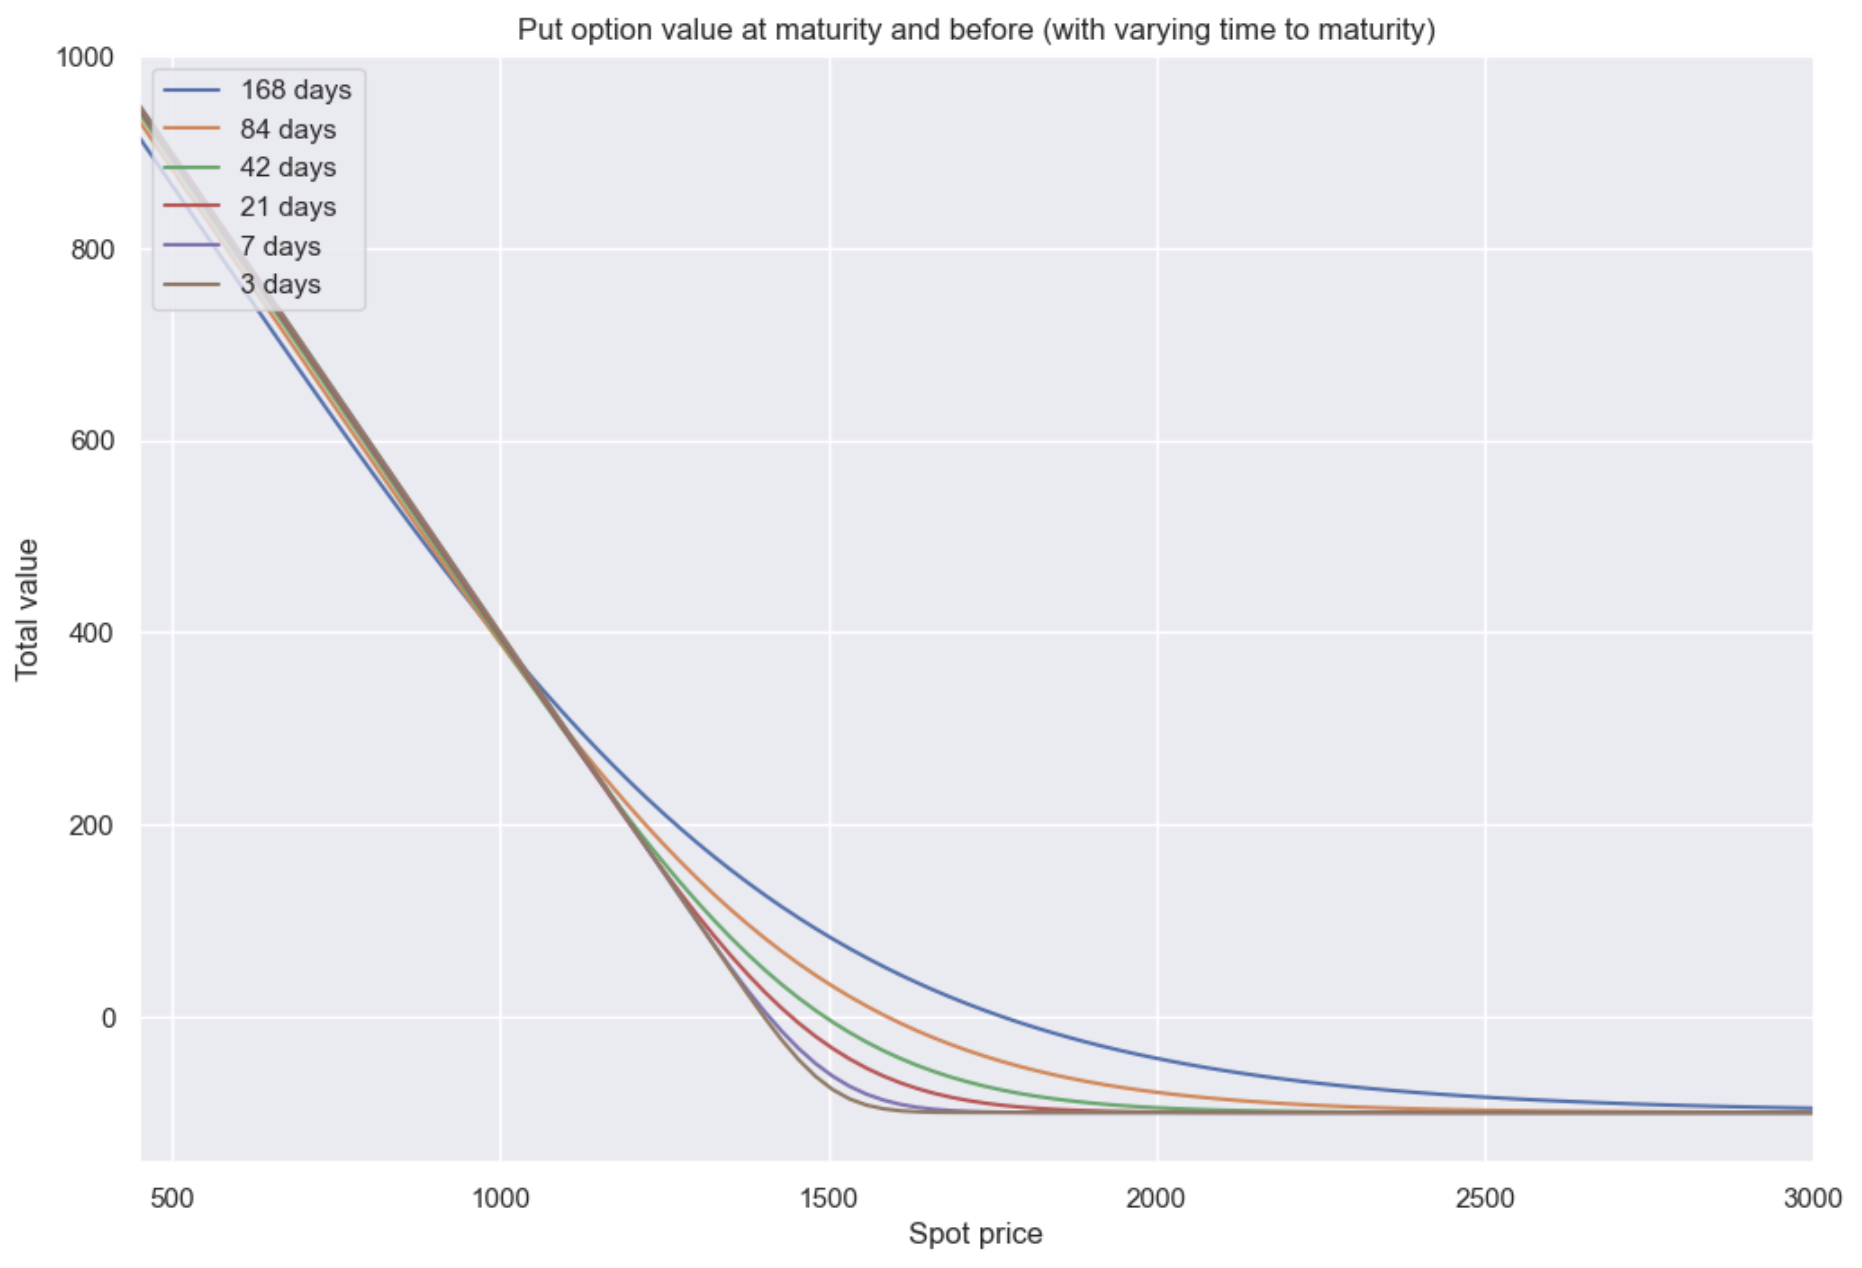

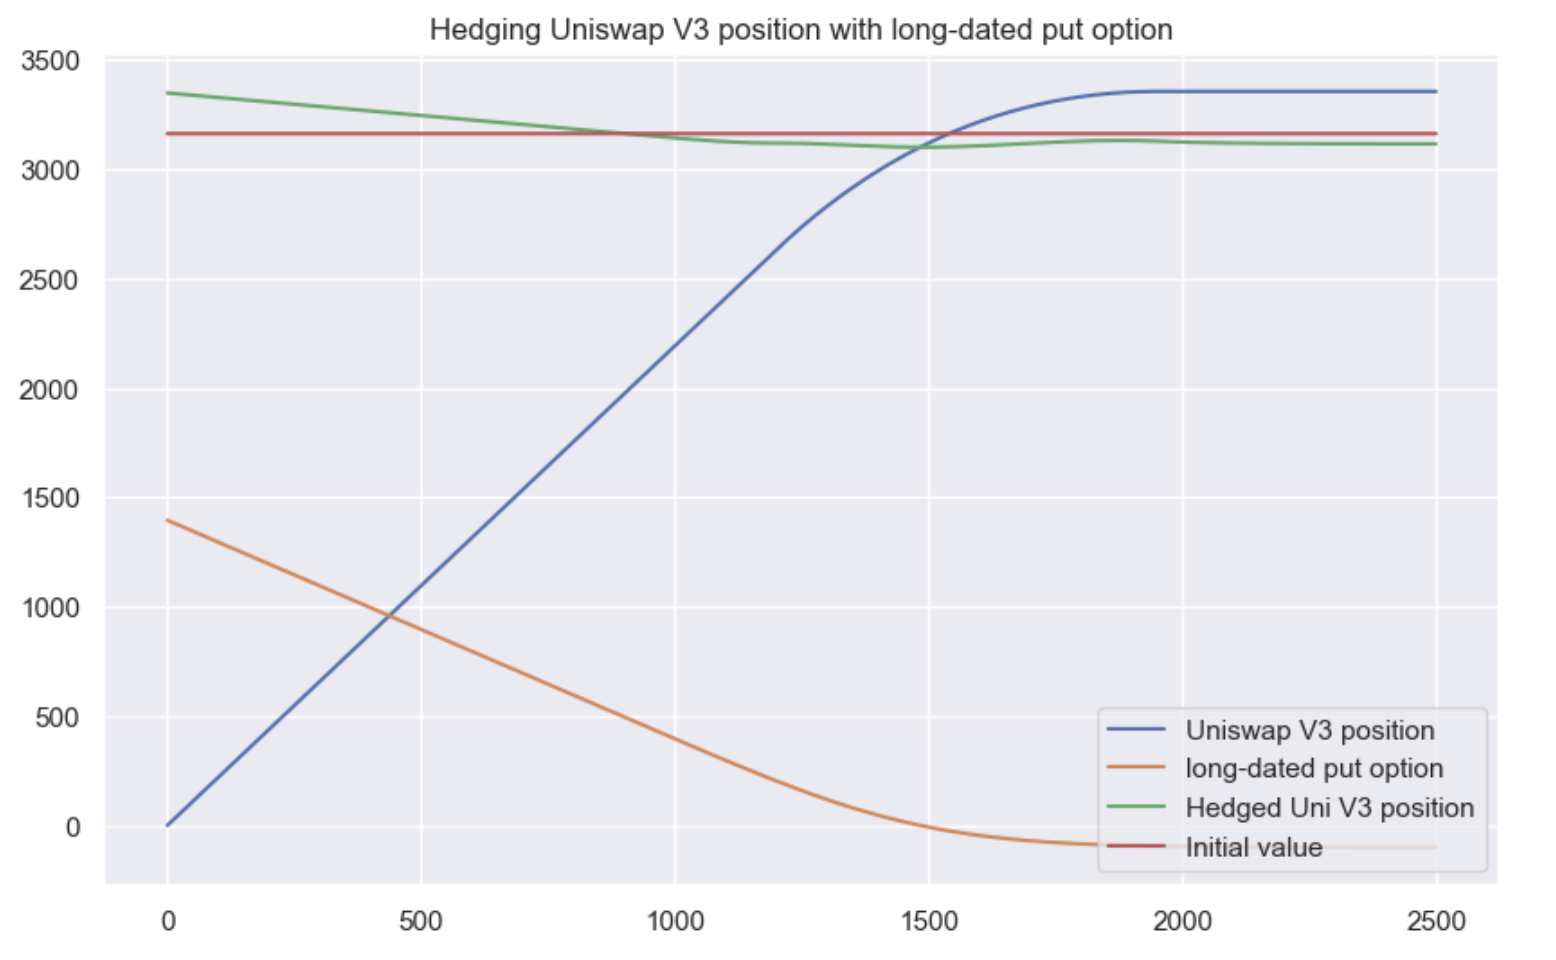

**То есть мы должны купить Put опцион с более поздней экспирацией, подержать этот опцион некоторое время и потом его продать. Тогда изогнутость опциона будет близка к Uniswap V3 позиции.**

### Будет ли полностью захеджированная Uniswap V3 позиция выгодна?

Детальный анализ показывает, что в большинстве случаев комиссии Uniswap V3 позиции не могут компенсировать затраты на опцион.
Но не всегда. Тем не менее, опционы можно рассматривать как хороший способ хеджировать риски (например, купить дешевый Out-of-the-money опцион за копейки, сильно ограничив свои убытки).